## Import Libraries

In [1]:
import os
import glob
import re
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
from torch.optim import AdamW

# Fix for torch.utils._pytree compatibility issue
if not hasattr(torch.utils._pytree, 'register_pytree_node'):
    torch.utils._pytree.register_pytree_node = lambda *args, **kwargs: None

from transformers import (
    BertTokenizer, 
    BertForSequenceClassification, 
    get_linear_schedule_with_warmup
)
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set random seeds for reproducibility
RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(RANDOM_SEED)

Using device: cuda


## Configuration

In [ ]:
# Data configuration
DATA_PATH = "Organized Normalized DGMs/all"
FEATURE_COLUMNS = None

# BERT configuration
MODEL_NAME = 'bert-base-uncased'
MAX_LENGTH = 128
BATCH_SIZE = 4
LEARNING_RATE = 2e-5
NUM_EPOCHS = 3
WARMUP_STEPS = 50
MAX_GRAD_NORM = 1.0


## Data Loading and Preprocessing with User ID Extraction

The DGM data is organized as:
```
all/
├── literate/
│   ├── user_1/
│   │   ├── user_1_question_10_ID_29_DGMs.csv
│   │   ├── user_1_question_12_ID_15_DGMs.csv
│   │   └── ...
│   ├── user_2/
│   └── ...
└── illiterate/
    ├── user_1/
    └── ...
```

**Note**: Each CSV file contains a single row with aggregated DGM features for one question.

In [3]:
class DGMDataset(Dataset):
    def __init__(self, data_path, tokenizer, max_length=512, normalize=True):
        self.data_path = data_path
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.normalize = normalize
        
        # Load all data files
        self.samples = []
        self.labels = []
        self.features = []
        self.user_ids = []
        
        self._load_data()
        self._preprocess_features()
        
    def _load_data(self):
        """Load CSV files from organized folder structure and extract user IDs"""
        print("Loading DGM data files...")
        
        # Define label mapping
        label_map = {'literate': 0, 'illiterate': 1}
        
        for label_name, label_value in label_map.items():
            label_path = os.path.join(self.data_path, label_name)
            
            if not os.path.exists(label_path):
                print(f"Warning: {label_path} does not exist")
                continue
            
            # Get all user folders
            user_folders = [d for d in os.listdir(label_path) 
                          if os.path.isdir(os.path.join(label_path, d)) and d.startswith('user_')]
            
            for user_folder in user_folders:
                # Extract user ID from folder name (e.g., 'user_1' -> 1)
                match = re.search(r'user_(\d+)', user_folder)
                if not match:
                    continue
                user_id = int(match.group(1))
                
                user_path = os.path.join(label_path, user_folder)
                csv_files = glob.glob(os.path.join(user_path, '*.csv'))
                
                for csv_file in csv_files:
                    try:
                        df = pd.read_csv(csv_file)
                        
                        # Each CSV file is one sample with a single row of aggregated features
                        if len(df) != 1:
                            print(f"Warning: {csv_file} has {len(df)} rows, expected 1. Using first row.")
                        
                        features = df.iloc[0].values
                        
                        self.samples.append(csv_file)
                        self.labels.append(label_value)
                        self.features.append(features)
                        self.user_ids.append(user_id)
                            
                    except Exception as e:
                        print(f"Error loading {csv_file}: {e}")
        
        print(f"Loaded {len(self.samples)} samples from {len(set(self.user_ids))} users")
        print(f"Label distribution: {pd.Series(self.labels).value_counts().to_dict()}")
        
    def _preprocess_features(self):
        """Normalize features and convert to text"""
        print("Preprocessing features...")
        
        # Convert to numpy array for easier manipulation
        features_array = np.array(self.features, dtype=float)
        
        if self.normalize:
            # Normalize each feature to [0, 1] range
            # Handle NaN and inf values
            features_array = np.nan_to_num(features_array, nan=0.0, posinf=1.0, neginf=0.0)
            
            # Min-max normalization per feature
            min_vals = np.min(features_array, axis=0)
            max_vals = np.max(features_array, axis=0)
            
            # Avoid division by zero
            range_vals = max_vals - min_vals
            range_vals[range_vals == 0] = 1.0
            
            features_array = (features_array - min_vals) / range_vals
        
        # Convert features to text representation (rounded to 3 decimals)
        self.text_features = []
        for features in features_array:
            # Convert numerical features to space-separated string
            text = ' '.join([f"{val:.3f}" for val in features])
            self.text_features.append(text)
        
        print("Feature preprocessing complete")
        
    def get_user_ids(self):
        """Return list of all user IDs"""
        return self.user_ids
    
    def get_unique_users(self):
        """Return sorted list of unique user IDs"""
        return sorted(set(self.user_ids))
        
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        text = self.text_features[idx]
        label = self.labels[idx]
        user_id = self.user_ids[idx]
        
        # Tokenize text
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long),
            'user_id': torch.tensor(user_id, dtype=torch.long)
        }

## Initialize Dataset and Tokenizer

In [4]:
# Initialize tokenizer
print("Loading BERT tokenizer...")
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

# Load dataset
print("\nLoading dataset...")
dataset = DGMDataset(
    data_path=DATA_PATH,
    tokenizer=tokenizer,
    max_length=MAX_LENGTH,
    normalize=True
)

print(f"\nDataset loaded successfully!")
print(f"Total samples: {len(dataset)}")
print(f"Number of unique users: {len(dataset.get_unique_users())}")
print(f"User IDs: {dataset.get_unique_users()}")

Loading BERT tokenizer...

Loading dataset...
Loading DGM data files...
Loaded 1499 samples from 30 users
Label distribution: {1: 849, 0: 650}
Preprocessing features...
Feature preprocessing complete

Dataset loaded successfully!
Total samples: 1499
Number of unique users: 30
User IDs: [1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]


## Training and Evaluation Functions

In [5]:
def train_epoch(model, dataloader, optimizer, scheduler, device, gradient_accumulation_steps=1):
    """Train for one epoch"""
    model.train()
    total_loss = 0
    predictions = []
    true_labels = []
    
    optimizer.zero_grad()
    
    progress_bar = tqdm(dataloader, desc="Training")
    for step, batch in enumerate(progress_bar):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        
        loss = outputs.loss / gradient_accumulation_steps
        loss.backward()
        
        if (step + 1) % gradient_accumulation_steps == 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), MAX_GRAD_NORM)
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
        
        total_loss += loss.item() * gradient_accumulation_steps
        
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)
        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())
        
        progress_bar.set_postfix({'loss': loss.item() * gradient_accumulation_steps})
    
    avg_loss = total_loss / len(dataloader)
    accuracy = accuracy_score(true_labels, predictions)
    
    return avg_loss, accuracy

def evaluate(model, dataloader, device):
    """Evaluate model"""
    model.eval()
    predictions = []
    true_labels = []
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)
            
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    
    accuracy = accuracy_score(true_labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(
        true_labels, predictions, average='macro', zero_division=0
    )
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'predictions': predictions,
        'true_labels': true_labels
    }

## Leave-One-User-Out Cross-Validation

For each user:
1. Use that user's data as test set
2. Use all other users' data as training set
3. Train model from scratch
4. Evaluate on held-out user
5. Store results

In [6]:
# Get unique users
unique_users = dataset.get_unique_users()
all_user_ids = dataset.get_user_ids()

print(f"Starting Leave-One-User-Out Cross-Validation")
print(f"Number of folds: {len(unique_users)}")
print(f"Unique users: {unique_users}")

# Store results
louo_results = []
all_predictions = []

# Perform LOUO CV
for fold_idx, test_user in enumerate(unique_users):
    print(f"\n{'='*80}")
    print(f"Fold {fold_idx + 1}/{len(unique_users)} - Testing on User {test_user}")
    print(f"{'='*80}")
    
    # Split data
    train_indices = [i for i, uid in enumerate(all_user_ids) if uid != test_user]
    test_indices = [i for i, uid in enumerate(all_user_ids) if uid == test_user]
    
    print(f"Training samples: {len(train_indices)}")
    print(f"Test samples: {len(test_indices)}")
    
    # Create subsets
    train_dataset = Subset(dataset, train_indices)
    test_dataset = Subset(dataset, test_indices)
    
    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
    
    # Initialize model
    model = BertForSequenceClassification.from_pretrained(
        MODEL_NAME,
        num_labels=2
    ).to(device)
    
    # Initialize optimizer and scheduler
    optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
    total_steps = len(train_loader) * NUM_EPOCHS
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=WARMUP_STEPS,
        num_training_steps=total_steps
    )
    
    # Training loop
    print(f"\nTraining for {NUM_EPOCHS} epochs...")
    for epoch in range(NUM_EPOCHS):
        print(f"\nEpoch {epoch + 1}/{NUM_EPOCHS}")
        train_loss, train_acc = train_epoch(
            model, train_loader, optimizer, scheduler, device,
            gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS
        )
        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
        
        # Clear cache
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
    
    # Evaluate on test set
    print(f"\nEvaluating on User {test_user}...")
    test_results = evaluate(model, test_loader, device)
    
    print(f"\nUser {test_user} Results:")
    print(f"  Accuracy:  {test_results['accuracy']:.4f}")
    print(f"  Precision: {test_results['precision']:.4f}")
    print(f"  Recall:    {test_results['recall']:.4f}")
    print(f"  F1-Score:  {test_results['f1']:.4f}")
    
    # Store results
    louo_results.append({
        'user_id': test_user,
        'accuracy': test_results['accuracy'],
        'precision': test_results['precision'],
        'recall': test_results['recall'],
        'f1': test_results['f1'],
        'n_samples': len(test_indices)
    })
    
    # Store predictions
    for i, (pred, true) in enumerate(zip(test_results['predictions'], test_results['true_labels'])):
        all_predictions.append({
            'user_id': test_user,
            'sample_idx': test_indices[i],
            'true_label': true,
            'predicted_label': pred
        })
    
    # Clean up
    del model, optimizer, scheduler
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

print(f"\n{'='*80}")
print("Leave-One-User-Out Cross-Validation Complete!")
print(f"{'='*80}")

Starting Leave-One-User-Out Cross-Validation
Number of folds: 30
Unique users: [1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]

Fold 1/30 - Testing on User 1
Training samples: 1449
Test samples: 50


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Training for 3 epochs...

Epoch 1/3


Training: 100%|██████████| 363/363 [00:15<00:00, 23.29it/s, loss=0.389]


Train Loss: 0.6897 | Train Acc: 0.5666

Epoch 2/3


Training: 100%|██████████| 363/363 [00:15<00:00, 23.87it/s, loss=0.903]


Train Loss: 0.6842 | Train Acc: 0.5839

Epoch 3/3


Training: 100%|██████████| 363/363 [00:15<00:00, 23.88it/s, loss=0.446]


Train Loss: 0.6840 | Train Acc: 0.5694

Evaluating on User 1...


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 64.85it/s]



User 1 Results:
  Accuracy:  0.0000
  Precision: 0.0000
  Recall:    0.0000
  F1-Score:  0.0000

Fold 2/30 - Testing on User 2
Training samples: 1449
Test samples: 50


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Training for 3 epochs...

Epoch 1/3


Training: 100%|██████████| 363/363 [00:15<00:00, 23.77it/s, loss=0.568]


Train Loss: 0.6965 | Train Acc: 0.5079

Epoch 2/3


Training: 100%|██████████| 363/363 [00:15<00:00, 23.77it/s, loss=0.834]


Train Loss: 0.6986 | Train Acc: 0.5376

Epoch 3/3


Training: 100%|██████████| 363/363 [00:15<00:00, 23.73it/s, loss=0.621]


Train Loss: 0.6965 | Train Acc: 0.5128

Evaluating on User 2...


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 66.10it/s]



User 2 Results:
  Accuracy:  1.0000
  Precision: 1.0000
  Recall:    1.0000
  F1-Score:  1.0000

Fold 3/30 - Testing on User 3
Training samples: 1449
Test samples: 50


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Training for 3 epochs...

Epoch 1/3


Training: 100%|██████████| 363/363 [00:15<00:00, 23.70it/s, loss=0.588]


Train Loss: 0.6965 | Train Acc: 0.5335

Epoch 2/3


Training: 100%|██████████| 363/363 [00:15<00:00, 23.77it/s, loss=0.558]


Train Loss: 0.6946 | Train Acc: 0.5238

Epoch 3/3


Training: 100%|██████████| 363/363 [00:15<00:00, 23.75it/s, loss=1.21] 


Train Loss: 0.6718 | Train Acc: 0.5645

Evaluating on User 3...


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 65.65it/s]



User 3 Results:
  Accuracy:  0.9400
  Precision: 0.5000
  Recall:    0.4700
  F1-Score:  0.4845

Fold 4/30 - Testing on User 4
Training samples: 1449
Test samples: 50


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Training for 3 epochs...

Epoch 1/3


Training: 100%|██████████| 363/363 [00:15<00:00, 23.73it/s, loss=0.966]


Train Loss: 0.6959 | Train Acc: 0.5549

Epoch 2/3


Training: 100%|██████████| 363/363 [00:15<00:00, 23.76it/s, loss=0.732]


Train Loss: 0.6848 | Train Acc: 0.5866

Epoch 3/3


Training: 100%|██████████| 363/363 [00:15<00:00, 23.76it/s, loss=0.402]


Train Loss: 0.6417 | Train Acc: 0.6418

Evaluating on User 4...


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 65.68it/s]



User 4 Results:
  Accuracy:  0.1800
  Precision: 0.5000
  Recall:    0.0900
  F1-Score:  0.1525

Fold 5/30 - Testing on User 6
Training samples: 1449
Test samples: 50


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Training for 3 epochs...

Epoch 1/3


Training: 100%|██████████| 363/363 [00:15<00:00, 23.73it/s, loss=0.872]


Train Loss: 0.6977 | Train Acc: 0.5273

Epoch 2/3


Training: 100%|██████████| 363/363 [00:15<00:00, 23.73it/s, loss=0.454]


Train Loss: 0.6849 | Train Acc: 0.5466

Epoch 3/3


Training: 100%|██████████| 363/363 [00:15<00:00, 23.75it/s, loss=0.474]


Train Loss: 0.6587 | Train Acc: 0.5935

Evaluating on User 6...


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 65.84it/s]



User 6 Results:
  Accuracy:  0.1000
  Precision: 0.5000
  Recall:    0.0500
  F1-Score:  0.0909

Fold 6/30 - Testing on User 7
Training samples: 1449
Test samples: 50


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Training for 3 epochs...

Epoch 1/3


Training: 100%|██████████| 363/363 [00:15<00:00, 23.74it/s, loss=0.686]


Train Loss: 0.7105 | Train Acc: 0.5238

Epoch 2/3


Training: 100%|██████████| 363/363 [00:15<00:00, 23.46it/s, loss=0.737]


Train Loss: 0.6768 | Train Acc: 0.5797

Epoch 3/3


Training: 100%|██████████| 363/363 [00:15<00:00, 23.46it/s, loss=0.481]


Train Loss: 0.6087 | Train Acc: 0.6763

Evaluating on User 7...


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 61.52it/s]



User 7 Results:
  Accuracy:  0.4200
  Precision: 0.5000
  Recall:    0.2100
  F1-Score:  0.2958

Fold 7/30 - Testing on User 8
Training samples: 1449
Test samples: 50


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Training for 3 epochs...

Epoch 1/3


Training: 100%|██████████| 363/363 [00:15<00:00, 23.45it/s, loss=0.514]


Train Loss: 0.6866 | Train Acc: 0.5631

Epoch 2/3


Training: 100%|██████████| 363/363 [00:15<00:00, 23.48it/s, loss=0.882]


Train Loss: 0.6803 | Train Acc: 0.5804

Epoch 3/3


Training: 100%|██████████| 363/363 [00:15<00:00, 23.73it/s, loss=0.413]


Train Loss: 0.6848 | Train Acc: 0.5742

Evaluating on User 8...


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 65.26it/s]



User 8 Results:
  Accuracy:  0.0000
  Precision: 0.0000
  Recall:    0.0000
  F1-Score:  0.0000

Fold 8/30 - Testing on User 9
Training samples: 1449
Test samples: 50


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Training for 3 epochs...

Epoch 1/3


Training: 100%|██████████| 363/363 [00:15<00:00, 23.72it/s, loss=0.494]


Train Loss: 0.6927 | Train Acc: 0.5549

Epoch 2/3


Training: 100%|██████████| 363/363 [00:15<00:00, 23.70it/s, loss=0.57] 


Train Loss: 0.6847 | Train Acc: 0.5687

Epoch 3/3


Training: 100%|██████████| 363/363 [00:15<00:00, 23.73it/s, loss=0.514]


Train Loss: 0.6802 | Train Acc: 0.5825

Evaluating on User 9...


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 65.53it/s]



User 9 Results:
  Accuracy:  0.0000
  Precision: 0.0000
  Recall:    0.0000
  F1-Score:  0.0000

Fold 9/30 - Testing on User 10
Training samples: 1449
Test samples: 50


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Training for 3 epochs...

Epoch 1/3


Training: 100%|██████████| 363/363 [00:15<00:00, 23.73it/s, loss=0.438]


Train Loss: 0.6870 | Train Acc: 0.5659

Epoch 2/3


Training: 100%|██████████| 363/363 [00:15<00:00, 23.72it/s, loss=1.13] 


Train Loss: 0.6775 | Train Acc: 0.5728

Epoch 3/3


Training: 100%|██████████| 363/363 [00:15<00:00, 23.76it/s, loss=0.968]


Train Loss: 0.6547 | Train Acc: 0.6197

Evaluating on User 10...


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 65.68it/s]



User 10 Results:
  Accuracy:  0.0000
  Precision: 0.0000
  Recall:    0.0000
  F1-Score:  0.0000

Fold 10/30 - Testing on User 11
Training samples: 1450
Test samples: 49


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Training for 3 epochs...

Epoch 1/3


Training: 100%|██████████| 363/363 [00:15<00:00, 23.72it/s, loss=0.457]


Train Loss: 0.6984 | Train Acc: 0.5097

Epoch 2/3


Training: 100%|██████████| 363/363 [00:15<00:00, 23.75it/s, loss=0.602]


Train Loss: 0.6959 | Train Acc: 0.5317

Epoch 3/3


Training: 100%|██████████| 363/363 [00:15<00:00, 23.74it/s, loss=0.68] 


Train Loss: 0.6988 | Train Acc: 0.5393

Evaluating on User 11...


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 66.07it/s]



User 11 Results:
  Accuracy:  0.0000
  Precision: 0.0000
  Recall:    0.0000
  F1-Score:  0.0000

Fold 11/30 - Testing on User 12
Training samples: 1449
Test samples: 50


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Training for 3 epochs...

Epoch 1/3


Training: 100%|██████████| 363/363 [00:15<00:00, 23.70it/s, loss=0.728]


Train Loss: 0.6947 | Train Acc: 0.5431

Epoch 2/3


Training: 100%|██████████| 363/363 [00:15<00:00, 23.74it/s, loss=0.567]


Train Loss: 0.6866 | Train Acc: 0.5507

Epoch 3/3


Training: 100%|██████████| 363/363 [00:15<00:00, 23.73it/s, loss=0.334]


Train Loss: 0.6573 | Train Acc: 0.6094

Evaluating on User 12...


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 65.75it/s]



User 12 Results:
  Accuracy:  0.0200
  Precision: 0.5000
  Recall:    0.0100
  F1-Score:  0.0196

Fold 12/30 - Testing on User 13
Training samples: 1449
Test samples: 50


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Training for 3 epochs...

Epoch 1/3


Training: 100%|██████████| 363/363 [00:15<00:00, 23.72it/s, loss=0.829]


Train Loss: 0.6986 | Train Acc: 0.5500

Epoch 2/3


Training: 100%|██████████| 363/363 [00:15<00:00, 23.74it/s, loss=0.78] 


Train Loss: 0.6969 | Train Acc: 0.5259

Epoch 3/3


Training: 100%|██████████| 363/363 [00:15<00:00, 23.73it/s, loss=0.68] 


Train Loss: 0.6922 | Train Acc: 0.5445

Evaluating on User 13...


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 65.18it/s]



User 13 Results:
  Accuracy:  1.0000
  Precision: 1.0000
  Recall:    1.0000
  F1-Score:  1.0000

Fold 13/30 - Testing on User 14
Training samples: 1449
Test samples: 50


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Training for 3 epochs...

Epoch 1/3


Training: 100%|██████████| 363/363 [00:15<00:00, 23.74it/s, loss=0.738]


Train Loss: 0.6854 | Train Acc: 0.5756

Epoch 2/3


Training: 100%|██████████| 363/363 [00:15<00:00, 23.73it/s, loss=0.663]


Train Loss: 0.6812 | Train Acc: 0.5804

Epoch 3/3


Training: 100%|██████████| 363/363 [00:15<00:00, 23.50it/s, loss=0.532]


Train Loss: 0.6850 | Train Acc: 0.5742

Evaluating on User 14...


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 65.62it/s]



User 14 Results:
  Accuracy:  0.0000
  Precision: 0.0000
  Recall:    0.0000
  F1-Score:  0.0000

Fold 14/30 - Testing on User 15
Training samples: 1449
Test samples: 50


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Training for 3 epochs...

Epoch 1/3


Training: 100%|██████████| 363/363 [00:15<00:00, 23.54it/s, loss=0.677]


Train Loss: 0.6964 | Train Acc: 0.5259

Epoch 2/3


Training: 100%|██████████| 363/363 [00:15<00:00, 23.54it/s, loss=0.499]


Train Loss: 0.6886 | Train Acc: 0.5369

Epoch 3/3


Training: 100%|██████████| 363/363 [00:15<00:00, 23.49it/s, loss=0.374]


Train Loss: 0.6664 | Train Acc: 0.5680

Evaluating on User 15...


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 62.78it/s]



User 15 Results:
  Accuracy:  1.0000
  Precision: 1.0000
  Recall:    1.0000
  F1-Score:  1.0000

Fold 15/30 - Testing on User 16
Training samples: 1449
Test samples: 50


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Training for 3 epochs...

Epoch 1/3


Training: 100%|██████████| 363/363 [00:15<00:00, 23.39it/s, loss=0.83] 


Train Loss: 0.6820 | Train Acc: 0.5839

Epoch 2/3


Training: 100%|██████████| 363/363 [00:15<00:00, 23.49it/s, loss=0.608]


Train Loss: 0.6887 | Train Acc: 0.5749

Epoch 3/3


Training: 100%|██████████| 363/363 [00:15<00:00, 23.47it/s, loss=0.824]


Train Loss: 0.6819 | Train Acc: 0.5735

Evaluating on User 16...


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 62.72it/s]



User 16 Results:
  Accuracy:  0.0000
  Precision: 0.0000
  Recall:    0.0000
  F1-Score:  0.0000

Fold 16/30 - Testing on User 17
Training samples: 1449
Test samples: 50


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Training for 3 epochs...

Epoch 1/3


Training: 100%|██████████| 363/363 [00:15<00:00, 23.49it/s, loss=0.622]


Train Loss: 0.6978 | Train Acc: 0.5231

Epoch 2/3


Training: 100%|██████████| 363/363 [00:15<00:00, 23.46it/s, loss=0.56] 


Train Loss: 0.6966 | Train Acc: 0.5273

Epoch 3/3


Training: 100%|██████████| 363/363 [00:15<00:00, 23.53it/s, loss=0.893]


Train Loss: 0.6922 | Train Acc: 0.5418

Evaluating on User 17...


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 63.90it/s]



User 17 Results:
  Accuracy:  1.0000
  Precision: 1.0000
  Recall:    1.0000
  F1-Score:  1.0000

Fold 17/30 - Testing on User 18
Training samples: 1449
Test samples: 50


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Training for 3 epochs...

Epoch 1/3


Training: 100%|██████████| 363/363 [00:15<00:00, 23.44it/s, loss=0.748]


Train Loss: 0.6985 | Train Acc: 0.5162

Epoch 2/3


Training: 100%|██████████| 363/363 [00:15<00:00, 23.47it/s, loss=0.989]


Train Loss: 0.6918 | Train Acc: 0.5438

Epoch 3/3


Training: 100%|██████████| 363/363 [00:15<00:00, 23.47it/s, loss=0.884]


Train Loss: 0.6871 | Train Acc: 0.5638

Evaluating on User 18...


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 65.61it/s]



User 18 Results:
  Accuracy:  0.0600
  Precision: 0.5000
  Recall:    0.0300
  F1-Score:  0.0566

Fold 18/30 - Testing on User 19
Training samples: 1449
Test samples: 50


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Training for 3 epochs...

Epoch 1/3


Training: 100%|██████████| 363/363 [00:15<00:00, 23.43it/s, loss=0.6]  


Train Loss: 0.7019 | Train Acc: 0.5135

Epoch 2/3


Training: 100%|██████████| 363/363 [00:15<00:00, 23.54it/s, loss=0.588]


Train Loss: 0.6957 | Train Acc: 0.5335

Epoch 3/3


Training: 100%|██████████| 363/363 [00:15<00:00, 23.51it/s, loss=0.75] 


Train Loss: 0.6948 | Train Acc: 0.5466

Evaluating on User 19...


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 63.70it/s]



User 19 Results:
  Accuracy:  0.0000
  Precision: 0.0000
  Recall:    0.0000
  F1-Score:  0.0000

Fold 19/30 - Testing on User 21
Training samples: 1449
Test samples: 50


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Training for 3 epochs...

Epoch 1/3


Training: 100%|██████████| 363/363 [00:15<00:00, 23.35it/s, loss=0.88] 


Train Loss: 0.6843 | Train Acc: 0.5742

Epoch 2/3


Training: 100%|██████████| 363/363 [00:15<00:00, 23.34it/s, loss=0.458]


Train Loss: 0.6798 | Train Acc: 0.5769

Epoch 3/3


Training: 100%|██████████| 363/363 [00:15<00:00, 23.43it/s, loss=0.486]


Train Loss: 0.6858 | Train Acc: 0.5666

Evaluating on User 21...


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 65.74it/s]



User 21 Results:
  Accuracy:  0.0000
  Precision: 0.0000
  Recall:    0.0000
  F1-Score:  0.0000

Fold 20/30 - Testing on User 22
Training samples: 1449
Test samples: 50


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Training for 3 epochs...

Epoch 1/3


Training: 100%|██████████| 363/363 [00:15<00:00, 23.46it/s, loss=0.738]


Train Loss: 0.7039 | Train Acc: 0.5210

Epoch 2/3


Training: 100%|██████████| 363/363 [00:15<00:00, 23.47it/s, loss=0.475]


Train Loss: 0.6811 | Train Acc: 0.5811

Epoch 3/3


Training: 100%|██████████| 363/363 [00:15<00:00, 23.48it/s, loss=0.279]


Train Loss: 0.6738 | Train Acc: 0.5811

Evaluating on User 22...


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 65.08it/s]



User 22 Results:
  Accuracy:  0.0000
  Precision: 0.0000
  Recall:    0.0000
  F1-Score:  0.0000

Fold 21/30 - Testing on User 23
Training samples: 1449
Test samples: 50


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Training for 3 epochs...

Epoch 1/3


Training: 100%|██████████| 363/363 [00:15<00:00, 23.14it/s, loss=1.19] 


Train Loss: 0.6961 | Train Acc: 0.5673

Epoch 2/3


Training: 100%|██████████| 363/363 [00:15<00:00, 22.73it/s, loss=0.401]


Train Loss: 0.6394 | Train Acc: 0.6225

Epoch 3/3


Training: 100%|██████████| 363/363 [00:15<00:00, 23.68it/s, loss=0.425]


Train Loss: 0.5601 | Train Acc: 0.6998

Evaluating on User 23...


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 65.64it/s]



User 23 Results:
  Accuracy:  0.1800
  Precision: 0.5000
  Recall:    0.0900
  F1-Score:  0.1525

Fold 22/30 - Testing on User 24
Training samples: 1449
Test samples: 50


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Training for 3 epochs...

Epoch 1/3


Training: 100%|██████████| 363/363 [00:15<00:00, 23.72it/s, loss=0.685]


Train Loss: 0.6922 | Train Acc: 0.5335

Epoch 2/3


Training: 100%|██████████| 363/363 [00:15<00:00, 23.76it/s, loss=1.03] 


Train Loss: 0.6941 | Train Acc: 0.5169

Epoch 3/3


Training: 100%|██████████| 363/363 [00:15<00:00, 23.73it/s, loss=0.682]


Train Loss: 0.6888 | Train Acc: 0.5631

Evaluating on User 24...


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 66.12it/s]



User 24 Results:
  Accuracy:  0.4400
  Precision: 0.5000
  Recall:    0.2200
  F1-Score:  0.3056

Fold 23/30 - Testing on User 25
Training samples: 1449
Test samples: 50


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Training for 3 epochs...

Epoch 1/3


Training: 100%|██████████| 363/363 [00:15<00:00, 23.75it/s, loss=0.571]


Train Loss: 0.6937 | Train Acc: 0.5383

Epoch 2/3


Training: 100%|██████████| 363/363 [00:15<00:00, 23.75it/s, loss=0.56] 


Train Loss: 0.6975 | Train Acc: 0.5259

Epoch 3/3


Training: 100%|██████████| 363/363 [00:15<00:00, 23.75it/s, loss=0.636]


Train Loss: 0.6884 | Train Acc: 0.5390

Evaluating on User 25...


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 65.21it/s]



User 25 Results:
  Accuracy:  1.0000
  Precision: 1.0000
  Recall:    1.0000
  F1-Score:  1.0000

Fold 24/30 - Testing on User 26
Training samples: 1449
Test samples: 50


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Training for 3 epochs...

Epoch 1/3


Training: 100%|██████████| 363/363 [00:15<00:00, 23.74it/s, loss=0.762]


Train Loss: 0.6876 | Train Acc: 0.5700

Epoch 2/3


Training: 100%|██████████| 363/363 [00:15<00:00, 23.73it/s, loss=0.589]


Train Loss: 0.6814 | Train Acc: 0.5901

Epoch 3/3


Training: 100%|██████████| 363/363 [00:15<00:00, 23.74it/s, loss=0.677]


Train Loss: 0.6832 | Train Acc: 0.5832

Evaluating on User 26...


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 64.89it/s]



User 26 Results:
  Accuracy:  0.0000
  Precision: 0.0000
  Recall:    0.0000
  F1-Score:  0.0000

Fold 25/30 - Testing on User 27
Training samples: 1449
Test samples: 50


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Training for 3 epochs...

Epoch 1/3


Training: 100%|██████████| 363/363 [00:15<00:00, 23.74it/s, loss=0.873]


Train Loss: 0.6938 | Train Acc: 0.5397

Epoch 2/3


Training: 100%|██████████| 363/363 [00:15<00:00, 23.74it/s, loss=0.554]


Train Loss: 0.6893 | Train Acc: 0.5404

Epoch 3/3


Training: 100%|██████████| 363/363 [00:15<00:00, 23.73it/s, loss=1.08] 


Train Loss: 0.6907 | Train Acc: 0.5431

Evaluating on User 27...


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 65.89it/s]



User 27 Results:
  Accuracy:  1.0000
  Precision: 1.0000
  Recall:    1.0000
  F1-Score:  1.0000

Fold 26/30 - Testing on User 28
Training samples: 1449
Test samples: 50


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Training for 3 epochs...

Epoch 1/3


Training: 100%|██████████| 363/363 [00:15<00:00, 23.73it/s, loss=0.883]


Train Loss: 0.6910 | Train Acc: 0.5611

Epoch 2/3


Training: 100%|██████████| 363/363 [00:15<00:00, 23.75it/s, loss=0.706]


Train Loss: 0.6833 | Train Acc: 0.5845

Epoch 3/3


Training: 100%|██████████| 363/363 [00:15<00:00, 23.72it/s, loss=0.712]


Train Loss: 0.6659 | Train Acc: 0.6073

Evaluating on User 28...


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 64.42it/s]



User 28 Results:
  Accuracy:  0.0600
  Precision: 0.5000
  Recall:    0.0300
  F1-Score:  0.0566

Fold 27/30 - Testing on User 29
Training samples: 1449
Test samples: 50


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Training for 3 epochs...

Epoch 1/3


Training: 100%|██████████| 363/363 [00:15<00:00, 23.47it/s, loss=1.28] 


Train Loss: 0.6863 | Train Acc: 0.5832

Epoch 2/3


Training: 100%|██████████| 363/363 [00:15<00:00, 23.46it/s, loss=0.628]


Train Loss: 0.6884 | Train Acc: 0.5645

Epoch 3/3


Training: 100%|██████████| 363/363 [00:15<00:00, 23.48it/s, loss=0.588]


Train Loss: 0.6753 | Train Acc: 0.5776

Evaluating on User 29...


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 65.03it/s]



User 29 Results:
  Accuracy:  0.8000
  Precision: 0.5000
  Recall:    0.4000
  F1-Score:  0.4444

Fold 28/30 - Testing on User 30
Training samples: 1449
Test samples: 50


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Training for 3 epochs...

Epoch 1/3


Training: 100%|██████████| 363/363 [00:15<00:00, 23.37it/s, loss=0.67] 


Train Loss: 0.6986 | Train Acc: 0.5197

Epoch 2/3


Training: 100%|██████████| 363/363 [00:15<00:00, 23.51it/s, loss=1.09] 


Train Loss: 0.6858 | Train Acc: 0.5673

Epoch 3/3


Training: 100%|██████████| 363/363 [00:15<00:00, 23.47it/s, loss=0.257]


Train Loss: 0.6472 | Train Acc: 0.6094

Evaluating on User 30...


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 62.21it/s]



User 30 Results:
  Accuracy:  0.9200
  Precision: 0.5000
  Recall:    0.4600
  F1-Score:  0.4792

Fold 29/30 - Testing on User 31
Training samples: 1449
Test samples: 50


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Training for 3 epochs...

Epoch 1/3


Training: 100%|██████████| 363/363 [00:15<00:00, 23.46it/s, loss=1.15] 


Train Loss: 0.6883 | Train Acc: 0.5673

Epoch 2/3


Training: 100%|██████████| 363/363 [00:15<00:00, 23.41it/s, loss=1.32] 


Train Loss: 0.6852 | Train Acc: 0.5604

Epoch 3/3


Training: 100%|██████████| 363/363 [00:15<00:00, 23.45it/s, loss=0.275]


Train Loss: 0.6548 | Train Acc: 0.5977

Evaluating on User 31...


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 61.27it/s]



User 31 Results:
  Accuracy:  0.1400
  Precision: 0.5000
  Recall:    0.0700
  F1-Score:  0.1228

Fold 30/30 - Testing on User 32
Training samples: 1449
Test samples: 50


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Training for 3 epochs...

Epoch 1/3


Training: 100%|██████████| 363/363 [00:15<00:00, 23.46it/s, loss=0.63] 


Train Loss: 0.7031 | Train Acc: 0.5079

Epoch 2/3


Training: 100%|██████████| 363/363 [00:15<00:00, 23.44it/s, loss=0.546]


Train Loss: 0.6945 | Train Acc: 0.5376

Epoch 3/3


Training: 100%|██████████| 363/363 [00:15<00:00, 23.48it/s, loss=0.615]


Train Loss: 0.6935 | Train Acc: 0.5362

Evaluating on User 32...


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 64.55it/s]


User 32 Results:
  Accuracy:  1.0000
  Precision: 1.0000
  Recall:    1.0000
  F1-Score:  1.0000

Leave-One-User-Out Cross-Validation Complete!


## Aggregate Results and Analysis

In [7]:
# Convert results to DataFrame
results_df = pd.DataFrame(louo_results)
predictions_df = pd.DataFrame(all_predictions)

# Calculate aggregate statistics
mean_accuracy = results_df['accuracy'].mean()
std_accuracy = results_df['accuracy'].std()
mean_precision = results_df['precision'].mean()
std_precision = results_df['precision'].std()
mean_recall = results_df['recall'].mean()
std_recall = results_df['recall'].std()
mean_f1 = results_df['f1'].mean()
std_f1 = results_df['f1'].std()

print("\nAggregate Results (Mean ± Std):")
print(f"Accuracy:  {mean_accuracy:.4f} ± {std_accuracy:.4f}")
print(f"Precision: {mean_precision:.4f} ± {std_precision:.4f}")
print(f"Recall:    {mean_recall:.4f} ± {std_recall:.4f}")
print(f"F1-Score:  {mean_f1:.4f} ± {std_f1:.4f}")

# Display per-user results
print("\nPer-User Results:")
print(results_df.sort_values('accuracy', ascending=False).to_string(index=False))

# Save results
results_df.to_csv('bert_dgms_louo_results.csv', index=False)
predictions_df.to_csv('bert_dgms_louo_predictions.csv', index=False)
print("\nResults saved to:")
print("  - bert_dgms_louo_results.csv")
print("  - bert_dgms_louo_predictions.csv")


Aggregate Results (Mean ± Std):
Accuracy:  0.3753 ± 0.4401
Precision: 0.4333 ± 0.3880
Recall:    0.3043 ± 0.4124
F1-Score:  0.3220 ± 0.4072

Per-User Results:
 user_id  accuracy  precision  recall       f1  n_samples
       2      1.00        1.0    1.00 1.000000         50
      15      1.00        1.0    1.00 1.000000         50
      13      1.00        1.0    1.00 1.000000         50
      27      1.00        1.0    1.00 1.000000         50
      32      1.00        1.0    1.00 1.000000         50
      17      1.00        1.0    1.00 1.000000         50
      25      1.00        1.0    1.00 1.000000         50
       3      0.94        0.5    0.47 0.484536         50
      30      0.92        0.5    0.46 0.479167         50
      29      0.80        0.5    0.40 0.444444         50
      24      0.44        0.5    0.22 0.305556         50
       7      0.42        0.5    0.21 0.295775         50
      23      0.18        0.5    0.09 0.152542         50
       4      0.18        0.

## Visualization

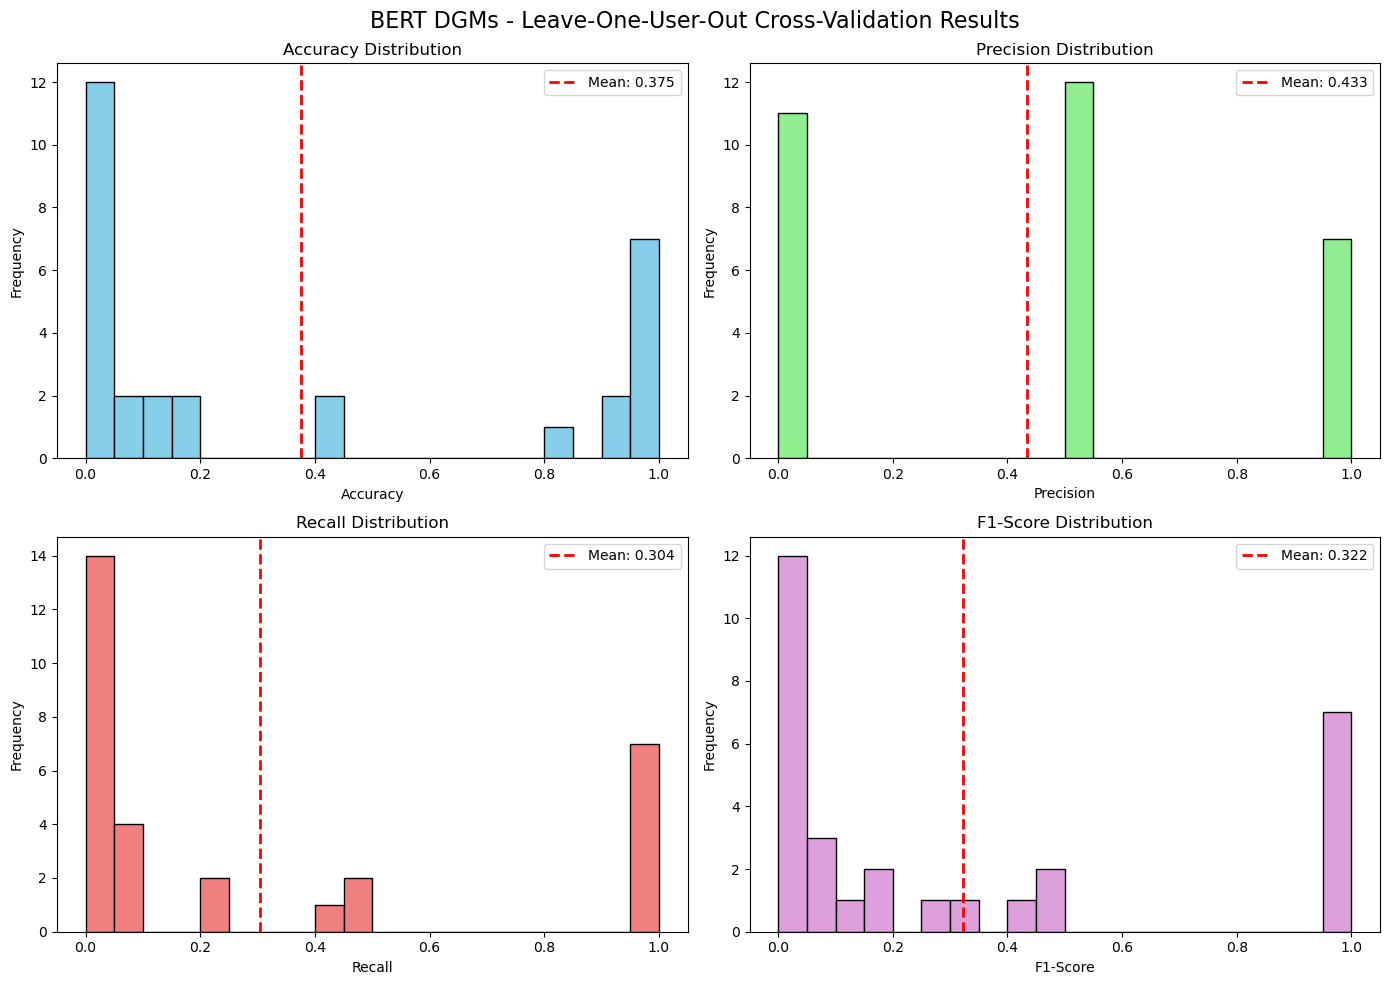

Visualization saved to: bert_dgms_louo_distribution.png


In [8]:
# Plot performance distribution
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('BERT DGMs - Leave-One-User-Out Cross-Validation Results', fontsize=16)

# Accuracy
axes[0, 0].hist(results_df['accuracy'], bins=20, color='skyblue', edgecolor='black')
axes[0, 0].axvline(mean_accuracy, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_accuracy:.3f}')
axes[0, 0].set_xlabel('Accuracy')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Accuracy Distribution')
axes[0, 0].legend()

# Precision
axes[0, 1].hist(results_df['precision'], bins=20, color='lightgreen', edgecolor='black')
axes[0, 1].axvline(mean_precision, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_precision:.3f}')
axes[0, 1].set_xlabel('Precision')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Precision Distribution')
axes[0, 1].legend()

# Recall
axes[1, 0].hist(results_df['recall'], bins=20, color='lightcoral', edgecolor='black')
axes[1, 0].axvline(mean_recall, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_recall:.3f}')
axes[1, 0].set_xlabel('Recall')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Recall Distribution')
axes[1, 0].legend()

# F1-Score
axes[1, 1].hist(results_df['f1'], bins=20, color='plum', edgecolor='black')
axes[1, 1].axvline(mean_f1, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_f1:.3f}')
axes[1, 1].set_xlabel('F1-Score')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('F1-Score Distribution')
axes[1, 1].legend()

plt.tight_layout()
plt.savefig('bert_dgms_louo_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("Visualization saved to: bert_dgms_louo_distribution.png")

## Box Plot of Metrics

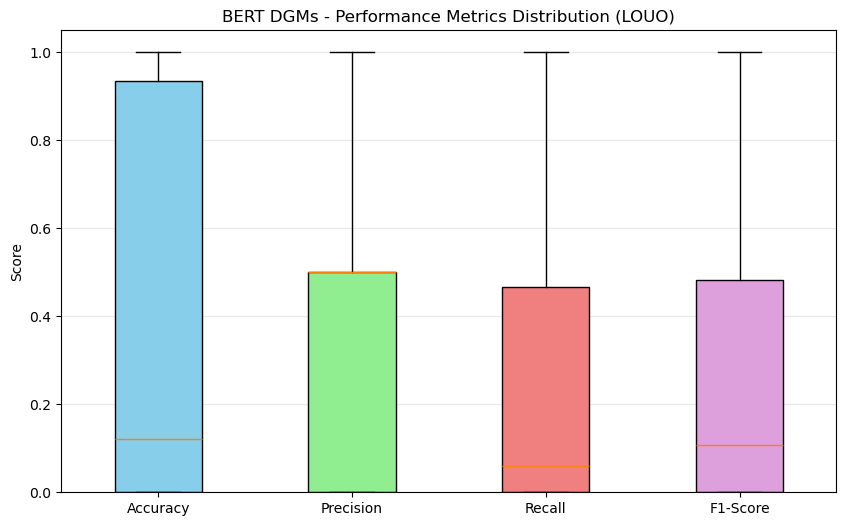

Box plot saved to: bert_dgms_louo_boxplot.png


In [9]:
plt.figure(figsize=(10, 6))
metrics_data = results_df[['accuracy', 'precision', 'recall', 'f1']]

bp = plt.boxplot([metrics_data['accuracy'], metrics_data['precision'], 
                   metrics_data['recall'], metrics_data['f1']],
                  labels=['Accuracy', 'Precision', 'Recall', 'F1-Score'],
                  patch_artist=True)

colors = ['skyblue', 'lightgreen', 'lightcoral', 'plum']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

plt.ylabel('Score')
plt.title('BERT DGMs - Performance Metrics Distribution (LOUO)')
plt.grid(axis='y', alpha=0.3)
plt.ylim(0, 1.05)
plt.savefig('bert_dgms_louo_boxplot.png', dpi=300, bbox_inches='tight')
plt.show()

print("Box plot saved to: bert_dgms_louo_boxplot.png")

## Statistical Summary

In [10]:
print("\nDetailed Statistical Summary:")
print("="*60)
summary_stats = results_df[['accuracy', 'precision', 'recall', 'f1']].describe()
print(summary_stats)

print("\n" + "="*60)
print("Top 5 Users by Accuracy:")
print(results_df.nlargest(5, 'accuracy')[['user_id', 'accuracy', 'f1', 'n_samples']])

print("\nBottom 5 Users by Accuracy:")
print(results_df.nsmallest(5, 'accuracy')[['user_id', 'accuracy', 'f1', 'n_samples']])


Detailed Statistical Summary:
        accuracy  precision     recall         f1
count  30.000000  30.000000  30.000000  30.000000
mean    0.375333   0.433333   0.304333   0.322036
std     0.440053   0.388040   0.412392   0.407186
min     0.000000   0.000000   0.000000   0.000000
25%     0.000000   0.000000   0.000000   0.000000
50%     0.120000   0.500000   0.060000   0.106858
75%     0.935000   0.500000   0.467500   0.483194
max     1.000000   1.000000   1.000000   1.000000

Top 5 Users by Accuracy:
    user_id  accuracy   f1  n_samples
1         2       1.0  1.0         50
11       13       1.0  1.0         50
13       15       1.0  1.0         50
15       17       1.0  1.0         50
22       25       1.0  1.0         50

Bottom 5 Users by Accuracy:
   user_id  accuracy   f1  n_samples
0        1       0.0  0.0         50
6        8       0.0  0.0         50
7        9       0.0  0.0         50
8       10       0.0  0.0         50
9       11       0.0  0.0         49
